In [1]:
import radvel
import numpy as np
import rebound as rb
import reboundx
import matplotlib.pyplot as plt
import celmech as cm
import pandas as pd
# pd.set_option('display.max_rows', None)
import h5py
from tqdm import tqdm
from scipy import optimize

/home/ianchow/.local/lib/python3.10/site-packages/radvel/gp.py:32: ImportWarning: celerite not installed. GP kernals using celerite will not work. Try installing celerite using 'pip install celerite'
  warnings.warn("celerite not installed. GP kernals using celerite will not work. \


Import data:

In [2]:
hd_data = pd.read_csv('hd45364_rvs.csv', sep = ';')
# giant outlier at position 116 in the data (found manually earlier) which we remove
hd_data.drop(116, inplace=True)  # drop the row and keep the df in place
# subtract 2.4e6 from all the rows in the data
hd_data.BJD -= 2.4e6

# get this data later somehow

# cluster_data = h5py.File('2021_fall-2022_winter/hd_mcmc_cluster.h5', 'r')  # import the posterior distribution data from the cluster
# accepted, samples, log_prob = np.array(cluster_data['mcmc']['accepted']), np.array(cluster_data['mcmc']['chain']), np.array(cluster_data['mcmc']['log_prob'])

# n_burn_in = 200  # discard the first 200 samples as burn-in time
# # reshape the chain to flatten it out
# flat_samples = samples[n_burn_in:].reshape(-1, samples[n_burn_in:].shape[-1])

In [3]:
# star mass, g and auday to m/s conversion factor
STAR_MASS = 920  # 920 jupiter masses
G = 2.825e-7  # converting G to jupiter masses, au, and days
AUDAY_MS = 1.731e6  # conversion factor to convert from au/day --> m/s

# use median of time data as the time base
obs_time_base = np.median(hd_data.BJD)

def mass_to_semiamp(planet_mass, star_mass, period, eccentricity, inclination):
    """
    planet mass (jupiter masses) to semi amplitude (in au/day)
    """
    return ((2 * np.pi * G/period) ** (1/3) * (planet_mass * np.sin(inclination) / star_mass ** (2/3)) * (1/np.sqrt(1 - eccentricity ** 2)))

def semiamp_to_mass(semiamp, star_mass, period, eccentricity, inclination):
    """
    semi amplitude (in au/day) to planet mass (jupiter masses)
    """
    return (((2 * np.pi * G/period) ** (-1/3)) * (semiamp / np.sin(inclination)) * np.sqrt(1 - eccentricity ** 2) * (star_mass ** (2/3)))


def get_sim_from_params(params, integrator, time_base, star_mass = STAR_MASS, auday_ms = AUDAY_MS):
    """
    takes in params array, returns a rebound Simulation object with those parameters
    
    param params: numpy array of params:
    
    for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is sin(i)
    params[5 * num_planets + 2] is jitter (not used in this specific function but used in some other functions that call this one)
    
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    param time_base: base time (to begin integration from) in the simulation
    """
    
    num_planets = int((len(params) - 1) / 5) # -2 because there are rv_offset and jit parameters:
    
    sim = rb.Simulation()
    sim.integrator = integrator
    sim.t = time_base  # keplerian and n-body models initialized at the same time offset
    # print(sim.t)
    if integrator == 'whfast':  # if using whfast integrator, set timestep
        sim.dt = 1/50 * min(params[0::5][:-1])  # timestep is 1/20th of the shortest orbital period of any planet
        # print(sim.dt)
    sim.units = ('AU', 'Mjupiter', 'day')
    sim.add(m = star_mass)  # star mass as a constant
    
    inclination = np.arcsin(params[-2])  # sin(i) is second from the back of the array
        
    for i in range (0, num_planets):
        # print(i)
        # planet parameters
        period = params[5*i]  # in days
        semiamp = params[5*i + 1] / auday_ms # divide by auday_ms because semiamp given in m/s
        eccentricity = params[5*i + 3] ** 2 + params[5*i + 4] ** 2  # eccentricity from secos, sesin
        omega = np.arctan2(params[5*i + 4], params[5*i + 3])  # omega from arctan of sesin, secos  (in that order!)
        # get tp by converting from tc
        tp = radvel.orbit.timetrans_to_timeperi(tc = params[5*i + 2], per = period, ecc = eccentricity, omega = omega)
        
        # mass
        mass = semiamp_to_mass(semiamp = semiamp, star_mass = star_mass, period = period, eccentricity = eccentricity, inclination = inclination)
        
        # adding to simulation
        sim.add(m = mass, P = period, e = eccentricity, T = tp, omega = omega, inc = inclination)
        
    sim.move_to_com()  # move to center of mass
    
    return sim

def get_simple_sim(masses, integrator = 'ias15', period_ratio = 3/2, epsilon=0.01):
    """
    gets simple sim (for eccentricity track stuff)
    param masses: array of planet masses
    param integrator: integrator
    param epsilon: amount by which the resonant period ratio should be offset from the equilibrium in the simulation
    """
    sim = rb.Simulation()
    sim.integrator = integrator
    # central star
    sim.add(m = 1)
    
    sim.add(m = masses[0], P = 1)
    sim.add(m = masses[1], P = period_ratio * (1 + epsilon))

    sim.move_to_com()
    if integrator == 'whfast':
        sim.dt = 1/50 * 1  # dy default use 1/50th of the inner planet's orbital period for the timestep if using whfast
    return sim


def get_rvs(params, times, integrator, time_base, auday_ms = AUDAY_MS):
    
    """
    Gets RVs from a Numpy array of planet params
    
    param params:     for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is sin(i) (also params[-2])
    params[5 * num_planets + 2] is jitter (also params[-1])
    
    param inclination: inclination of system in the observation plane (pi/2 is in the plane of the sky, 0 is edge-on)
    param times: array of times to integrate over
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    
    """
    
    sim = get_sim_from_params(params, integrator, time_base = time_base)
    
    sim_backwards = sim.copy()
    sim_backwards.dt *= -1  # set timestep to be negative if integrating backwards
    
    forward_times = np.array(list(filter(lambda x: x - time_base >= 0, times)))
    backward_times = np.array(list(filter(lambda x: x - time_base < 0, times)))
    
    # initialize rvs
    rv_forward = np.zeros(len(forward_times))
    rv_backward = np.zeros(len(backward_times))
    
    num_planets = int((len(params) - 1) / 5)  # find number of planets in params passed
    
    # get the rvs (z velocity, assuming 90 deg inclination) from the rebound simulation to compare with the actual simulation
    for i, t in enumerate(forward_times):
        sim.integrate(t, exact_finish_time = 1)
        # integrate to the specified time, exact_finish_time = 1 for ias15, 
        # sim.status()
        star = sim.particles[0]
        rv_forward[i] = (-star.vz * auday_ms) + params[5 * num_planets]  # use x-velocity of the star as the radial velocity, convert to m/s
    
    for i, t in enumerate(backward_times):
        sim_backwards.integrate(t, exact_finish_time = 1)
        star = sim_backwards.particles[0]
        rv_backward[i] = (-star.vz * auday_ms) + params[5 * num_planets]
    
    return np.concatenate((rv_backward, rv_forward))

In [4]:
#Very original parameters used in Hadden and Payne
nbody_params =[ 2.27798546e+02,  7.25405874e+00,  5.39392010e+04,  1.71866112e-01, 
               1.17923823e-01,  3.43881599e+02,  1.87692753e+01,  5.40138425e+04, 
               1.68408461e-01,  5.05903191e-02, -3.28526403e-03, 1, 1.84]

# 13 total parameters
# 2 x 5 sets of planet parameters (indices 0-4 and 5-9), followed by rv offset (10), sin(i) (11) and then jitter (12)

#Least squares fit: 
fit_params = [ 2.28512793e+02, 7.27736501e+00, 5.39371914e+04, -4.66868256e-02, 
               -1.78080009e-01, 3.43378038e+02, 1.78603341e+01, 5.40186750e+04, 
               9.72945632e-02,  1.32194117e-01, -5.29072002e-01, 1, 2.428]#-7.68527759e-03] 

# this includes jitter! the last term is taken from the post params with pickle (nbody_params in the original ipynb)

Define a negative log-likelihood function to minimize for the least-squares fit with jitter, using equation (1) from this paper https://iopscience.iop.org/article/10.1088/0004-637X/794/1/51/pdf 

In [5]:
def neg_log_likelihood(params, data = hd_data):
    """
    Gets the negative log-likelihood (including a jitter term!) for use with scipy.optimize.minimze
    
    Iplements the log likelihood using the same method above
    
    """
    obs_y = data.RV_mlc_nzp  # observed RVs
    jitter = params[-1]  # jitter is at the back of the parameter array, and is handeld separately
    # inclination not handled sparately
    # inclination = np.arcsin(params[-2])  # inclination is np.arcsin of the second to last parameter
    
    synth_y = get_rvs(params, data.BJD, 'ias15', time_base = obs_time_base)  # RVs from the rebound simulation
    obs_yerr = data.e_RV_mlc_nzp  # y errors
    
    log_likelihood = -1/2 * np.sum(((obs_y - synth_y) ** 2)/(obs_yerr ** 2 + jitter ** 2) 
                                   + np.log(np.sqrt(2 * np.pi * (obs_yerr ** 2 + jitter ** 2))))
    
    # log_likelihood = -1/2 * np.sum(np.log(variance) + ((obs_y - synth_y) ** 2/variance))
    
    return -log_likelihood  # negative since we are trying to minimize the negative log likelihood
    

In [6]:
# test on fit_params
neg_log_likelihood(fit_params)

151.03485967948023

Now find the fit by maximizing the log likelihood (minimizing the negative log likelihood), with appropriate bounds (bounds of [0, 1] for sin(i))

In [7]:
# bounds of (0, 1) for sin(i), everything else can vary however
bounds = ((None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (None, None), (0, 1) ,(None, None))

best_fit_jitter = optimize.minimize(neg_log_likelihood, x0=np.array(fit_params), method='Nelder-Mead', bounds=bounds, options={'maxiter': int(1e5), 'maxfev': int(1e5)})  # optimization

In [8]:
neg_log_likelihood(nbody_params), neg_log_likelihood(best_fit_jitter.x)

(333.45038345637624, 144.46967219237797)

In [9]:
print(f'original guess:\n{np.array(fit_params)}\n\noptimization with jitter:\n{best_fit_jitter.x}\n\n', best_fit_jitter)

original guess:
[ 2.28512793e+02  7.27736501e+00  5.39371914e+04 -4.66868256e-02
 -1.78080009e-01  3.43378038e+02  1.78603341e+01  5.40186750e+04
  9.72945632e-02  1.32194117e-01 -5.29072002e-01  1.00000000e+00
  2.42800000e+00]

optimization with jitter:
[ 2.27437531e+02  7.22197744e+00  5.39396185e+04 -4.90217304e-02
 -1.84977923e-01  3.43958640e+02  1.78991175e+01  5.40179404e+04
  8.42284121e-02  1.30719007e-01 -5.37541349e-01  1.00000000e+00
  2.44548793e+00]

        message: Optimization terminated successfully.
       success: True
        status: 0
           fun: 144.46967219237797
             x: [ 2.274e+02  7.222e+00 ...  1.000e+00  2.445e+00]
           nit: 3556
          nfev: 4862
 final_simplex: (array([[ 2.274e+02,  7.222e+00, ...,  1.000e+00,
                         2.445e+00],
                       [ 2.274e+02,  7.222e+00, ...,  1.000e+00,
                         2.445e+00],
                       ...,
                       [ 2.274e+02,  7.222e+00, ...,  1.000e

**NBODY_VS_PREV_FINAL equivalent but using the jitter fit parameters instead of the original fit parameters without any jitter**:

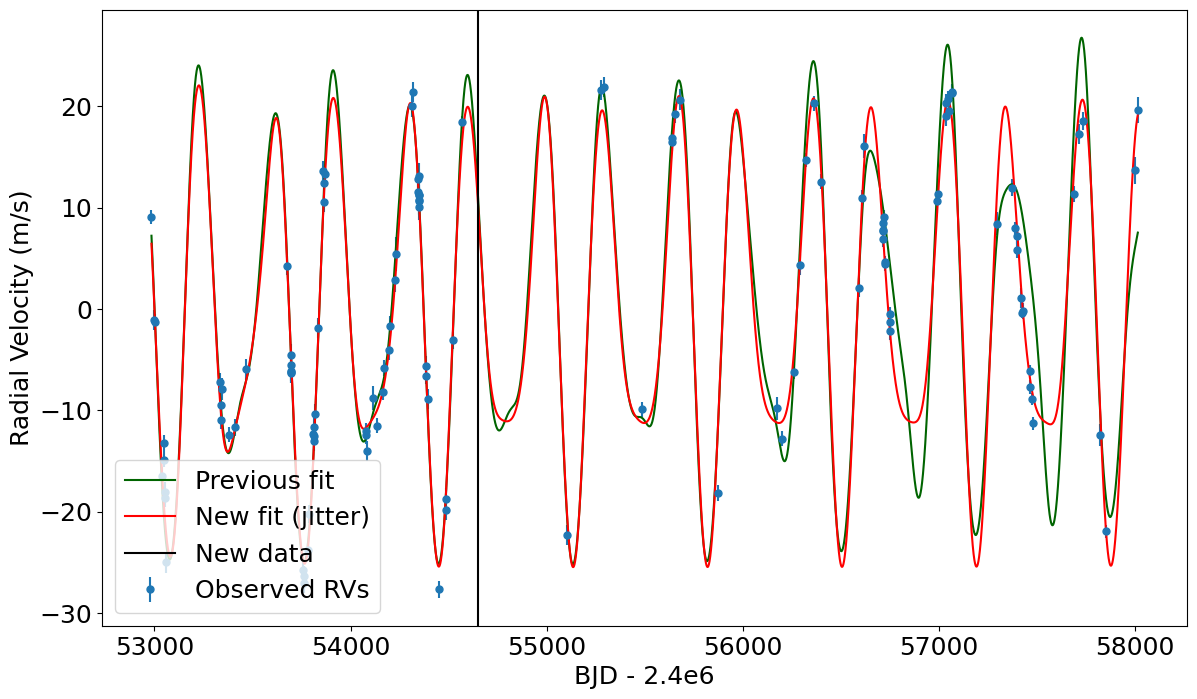

In [10]:
plt.figure(figsize=(14, 8))
plt.rc('font', size = 18)
# pltot the observed RVs
plt.errorbar(hd_data.BJD, hd_data.RV_mlc_nzp, yerr = hd_data.e_RV_mlc_nzp, fmt= 'o', label = 'Observed RVs')
times = np.linspace(np.min(hd_data.BJD), np.max(hd_data.BJD), int(1e4))  # time array
# pltot the REBOUND n-body reuslt for original parameters and least-squares fit
plt.plot(times, get_rvs(nbody_params, times, 'ias15', obs_time_base), label = 'Previous fit', color='darkgreen')#, color='black')
# plt.plot(times, get_rvs(fit_params, np.pi/2, times, 'ias15', obs_time_base), label = 'New fit (no jitter)', color='orange')#, color='orange')
plt.plot(times, get_rvs(best_fit_jitter.x, times, 'ias15', obs_time_base), label = 'New fit (jitter)', color='red')
# pltot the Keplterian result
# plt.pltot(times, post.model(times), label = 'Keplterian')
plt.axvline(x = 54650, color='black', label='New data')
plt.xlabel('BJD - 2.4e6'), plt.ylabel('Radial Velocity (m/s)')
# plt.ylim(bottom = -30)
# plt.title('N-body least-squares fit vs. previous fit')
plt.legend(loc = 'lower left')
plt.savefig('nbody_vs_prev_final_jitter.png', pad_inches=0)# fmt = 'png', pad_inches = 0)

Compare to the observed RV data:

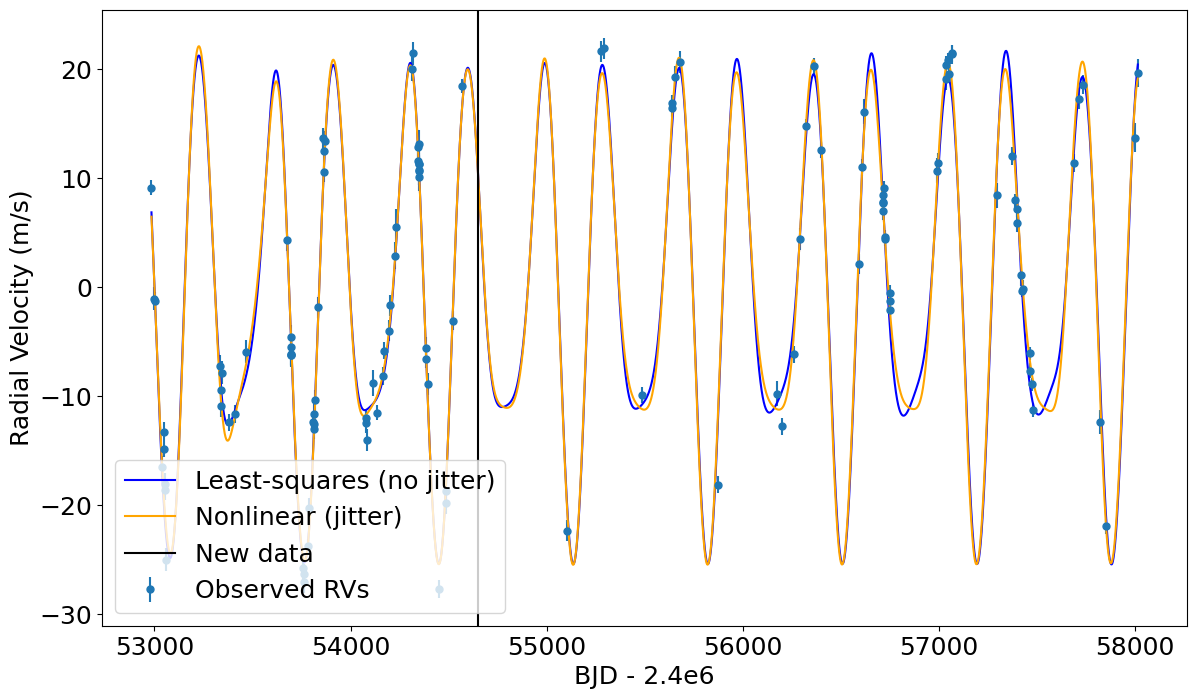

In [11]:
plt.figure(figsize=(14, 8))
plt.rc('font', size = 18)
# plot observed RVs
plt.errorbar(hd_data.BJD, hd_data.RV_mlc_nzp, yerr = hd_data.e_RV_mlc_nzp, fmt= 'o', label = 'Observed RVs')
# plot the RV curve for original least-squares optimization (without jitter) and the nonlinear optimization (with jitter)
times = np.linspace(np.min(hd_data.BJD), np.max(hd_data.BJD), int(1e4))  # time array
# original least squares optimization (no jitter)
plt.plot(times, get_rvs(fit_params, times, 'ias15', obs_time_base), label = 'Least-squares (no jitter)', color='blue')
# nonlinear optimization (jitter)
plt.plot(times, get_rvs(best_fit_jitter.x, times, 'ias15', obs_time_base), label = 'Nonlinear (jitter)', color='orange')
plt.axvline(x = 54650, c='k', label = 'New data')
plt.xlabel('BJD - 2.4e6'), plt.ylabel('Radial Velocity (m/s)')
plt.legend(loc = 'lower left')
plt.show()


Now changing jitter, holding the planet parameters constant and plotting likelihood as a function of jitter for the original solution without jitter as a parameter and the solution with jitter as a parameter

In [12]:
jitters = np.linspace(0, 10, int(1e3))  # try 100 from 0 to 1

# without jitter as a parameter set of params
no_jitter_neg_log_likelihoods = [neg_log_likelihood(np.append(fit_params[:-1], jitter)) for jitter in jitters]
# jitter as a parameter set of params
jitter_neg_log_likelihoods = [neg_log_likelihood(np.append(best_fit_jitter.x[:-1], jitter)) for jitter in jitters]  # compute negative log likelihood for each

And plot:

In [13]:
neg_log_likelihood(np.append(best_fit_jitter.x[:-1], 3.29480198e-04))

326.38555958225953

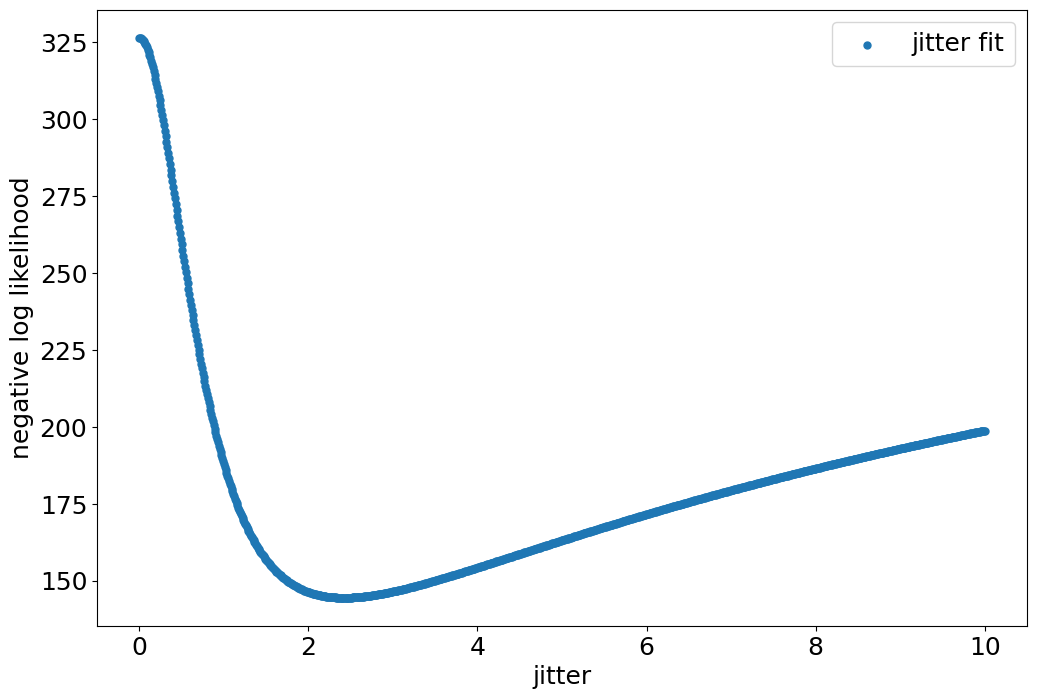

In [14]:
plt.figure(figsize = (12, 8))
# no jitter fit
# plt.scatter(jitters, no_jitter_neg_log_likelihoods, label = 'no jitter fit')
# jitter fit
plt.scatter(jitters, jitter_neg_log_likelihoods, label = 'jitter fit')
plt.xlabel('jitter'), plt.ylabel('negative log likelihood')
plt.legend()
plt.show()

In [15]:
# jitter that produces the minimum negative log likelihood for different values
jitters[np.argmin(no_jitter_neg_log_likelihoods)], jitters[np.argmin(jitter_neg_log_likelihoods)]

(2.7027027027027026, 2.4224224224224224)

In [16]:
# minimum negative log likelihood
neg_log_likelihood(params=np.append(best_fit_jitter.x[:-1], jitters[np.argmin(jitter_neg_log_likelihoods)]))

144.46480310820246

Try optimizing again with the jitter producing the minimum negative log likelihood

In [17]:
best_fit_jitter2 = optimize.minimize(neg_log_likelihood, x0=np.append(best_fit_jitter.x[:-1], jitters[np.argmin(jitter_neg_log_likelihoods)]), method='Nelder-Mead', bounds=bounds, options={'maxiter': int(1e5), 'maxfev': int(1e5)})  # optimization

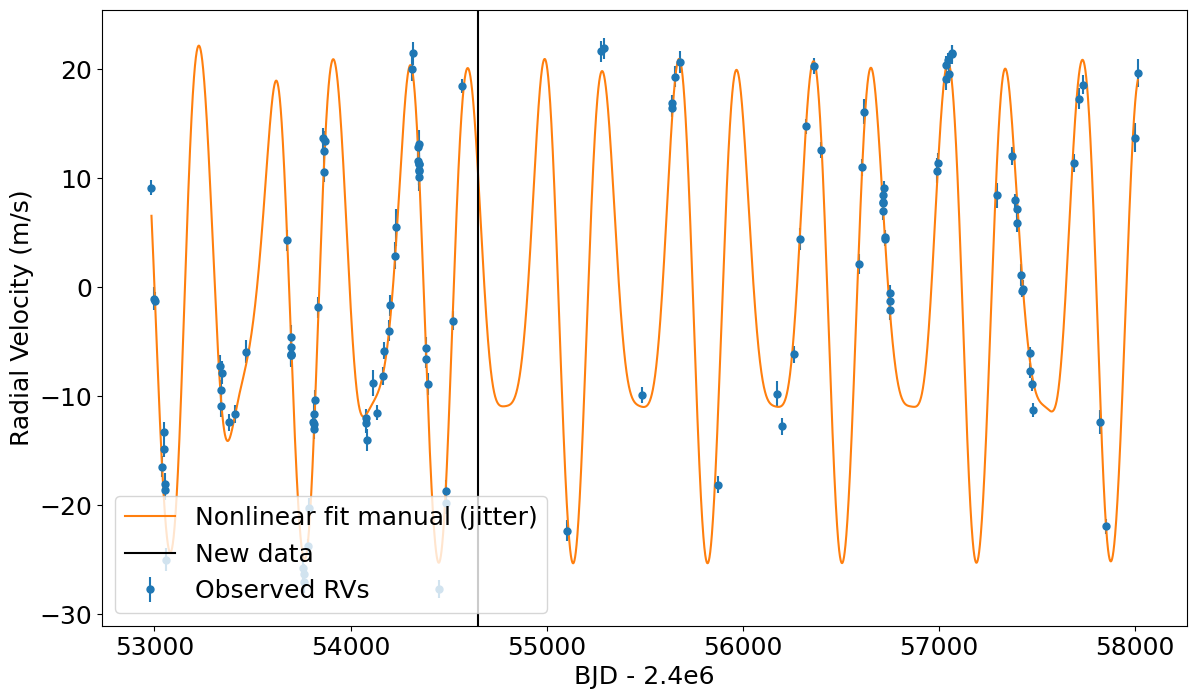

In [18]:
plt.figure(figsize=(14, 8))
plt.rc('font', size = 18)
# plot observed RVs
plt.errorbar(hd_data.BJD, hd_data.RV_mlc_nzp, yerr = hd_data.e_RV_mlc_nzp, fmt= 'o', label = 'Observed RVs')
# plot the RV curve for original least-squares optimization (without jitter) and the nonlinear optimization (with jitter)
times = np.linspace(np.min(hd_data.BJD), np.max(hd_data.BJD), int(1e4))  # time array
# original least squares optimization (no jitter)
# plt.plot(times, get_rvs(fit_params, np.pi/2, times, 'ias15', obs_time_base), label = 'Least-squares (no jitter)', color='blue')
# nonlinear optimization (jitter)
# plt.plot(times, get_rvs(best_fit_jitter.x, np.pi/2, times, 'ias15', obs_time_base), label = 'Nonlinear fit from LS solution (jitter)', color='orange')
# nonlinear optimization (jitter) with the jitter producing the minimum negative log likelihood manually added
plt.plot(times, get_rvs(best_fit_jitter2.x, times, 'ias15', obs_time_base), label = 'Nonlinear fit manual (jitter)')
plt.axvline(x = 54650, c='k', label = 'New data')
plt.xlabel('BJD - 2.4e6'), plt.ylabel('Radial Velocity (m/s)')
plt.legend(loc = 'lower left')
plt.show()

Check likelihood and compare:

In [19]:
neg_log_likelihood(fit_params), neg_log_likelihood(best_fit_jitter.x), neg_log_likelihood(best_fit_jitter2.x)

(151.03485967948023, 144.46967219237797, 144.40169808152174)

In [20]:
fit_params, best_fit_jitter.x, best_fit_jitter2.x

([228.512793,
  7.27736501,
  53937.1914,
  -0.0466868256,
  -0.178080009,
  343.378038,
  17.8603341,
  54018.675,
  0.0972945632,
  0.132194117,
  -0.529072002,
  1,
  2.428],
 array([ 2.27437531e+02,  7.22197744e+00,  5.39396185e+04, -4.90217304e-02,
        -1.84977923e-01,  3.43958640e+02,  1.78991175e+01,  5.40179404e+04,
         8.42284121e-02,  1.30719007e-01, -5.37541349e-01,  1.00000000e+00,
         2.44548793e+00]),
 array([ 2.27547902e+02,  7.22898423e+00,  5.39387827e+04,  3.17729699e-03,
        -1.75803674e-01,  3.43890259e+02,  1.79006048e+01,  5.40176450e+04,
         9.66009456e-02,  1.34537629e-01, -5.17101949e-01,  1.00000000e+00,
         2.41896624e+00]))

Create a 2D grid of $A_{0}$ and jitter, then for each point hold them constant while optimizing the parameters using least-squares (or nonlinear) and compute the likelihood 

In [21]:
njitter, nlib = (50, 50)  # can change this
# create jitter and A_0 points
jitters = np.linspace(0.5, 5, njitter)  # use 1 to 6 for jitter as recommended
Alibs = np.linspace(1, 0.05, nlib)  # use Alib 1 to 0.05
# create meshgrid
jitters_grid, Alibs_grid = np.meshgrid(jitters, Alibs)

Optimize the parameters using least squares while holding $A_{0}$ and jitter constant for each point, then compute the likelihood ($\chi^2$) just of the fit for each point:

In [22]:
def get_rvs_jitter(params, jitter, times, integrator, time_base, auday_ms = AUDAY_MS):
    
    """
    Gets RVs from a Numpy array of planet params, taking into account a jitter term
    
    param params:     for i in range(0, num_planets):
    
    params[i + 0] is period
    params[i + 1] is semiamp
    params[i + 2] is tc (time of conjunction)
    params[i + 3] is sqrt(e) * cos(omega)
    params[i + 4] is sqrt(e) * sin(omega)
    
    params[5 * num_planets] is rv offset
    params[5 * num_planets + 1] is sin(i)
    
    param jitter: constant jitter
    param times: array of times to integrate over
    param integrator: integrator to use, one of 'whfast' or 'ias15'
    
    """
    
    sim = get_sim_from_params(params, integrator, time_base = time_base)
    
    sim_backwards = sim.copy()
    sim_backwards.dt *= -1  # set timestep to be negative if integrating backwards
    
    forward_times = np.array(list(filter(lambda x: x - time_base >= 0, times)))
    backward_times = np.array(list(filter(lambda x: x - time_base < 0, times)))
    
    # initialize rvs
    rv_forward = np.zeros(len(forward_times))
    rv_backward = np.zeros(len(backward_times))
    
    num_planets = int((len(params) - 1) / 5)  # find number of planets in params passed
    
    # get the rvs (z velocity, assuming 90 deg inclination) from the rebound simulation to compare with the actual simulation
    for i, t in enumerate(forward_times):
        sim.integrate(t, exact_finish_time = 1)
        # integrate to the specified time, exact_finish_time = 1 for ias15, 
        # sim.status()
        star = sim.particles[0]
        rv_forward[i] = (-star.vz * auday_ms) + params[5 * num_planets]  # use x-velocity of the star as the radial velocity, convert to m/s

    for i, t in enumerate(backward_times):
        sim_backwards.integrate(t, exact_finish_time = 1)
        star = sim_backwards.particles[0]
        rv_backward[i] = (-star.vz * auday_ms) + params[5 * num_planets]
    
    return np.concatenate((rv_backward, rv_forward))

def get_nbody_resids_jitter_libration(params, jitter, Alib, integrator='ias15', data=hd_data, time_base=np.median(hd_data.BJD)):
    """
    Gets the normalized residuals for the n-body fit with REBOUND, penalizing for the RMS of the libration angle a 
    and for jitter, holding each of them constant (this is the function we want to optimize)
    
    params is in the form of params for the 10-param model (n-body rebound) rather than the 7-param equilibrium model (keplerian)
    
    Alib is 0.01 by default
    """
    
    # times
    times = data.BJD
    
    # compute normalized residuals
    obs_y = data.RV_mlc_nzp  # observed RVs
    # get rvs holding jitter constant
    synth_y = get_rvs(params, times, integrator, time_base)  # RVs from the rebound simulation
    obs_yerr = data.e_RV_mlc_nzp  # y errors
    # compute normalized residuals including jitter term
    jitter_normalized_resids = (obs_y - synth_y)/np.sqrt(obs_yerr ** 2 + jitter ** 2)  # compute normalized residuals using rebound
    # compute the rms of the libration angle a (find libration angles from omega using a rebound simulation)
    nperiods = 500  # number of peirods
    # measure the libration amplitude over 1000 periods of the inner planet (longer time array than for the residuals)
    nsamples = 1000
    # define p1
    p1 = params[0]
    angle_times = np.linspace(0, 0 + p1 * nperiods, nsamples)  # angle times, use length of observed rvs
    angle_time_base = 0#np.median(angle_times)  # reset angle time base to something else to find the libration amplitude 
    # initialize sim
    angle_sim = get_sim_from_params(params, integrator='whfast', time_base=0)
    inner = angle_sim.particles[1]
    outer = angle_sim.particles[2]
    # define empty arrays
    angle1, angle2 = np.zeros((2, nsamples))  # init empty arrays
    # now compute the libration angle arrays
    # test2 = np.zeros(len(angle_times))
    for i, t in enumerate(angle_times):
        angle_sim.integrate(t, exact_finish_time = 0)
        resonant_angle = 3 * outer.l - 2 * inner.l  # 3*lambda_2 - 2*lambda_1
        # test2[i] = resonant_angle
        angle1[i] = np.mod(resonant_angle - inner.pomega, 2 * np.pi)  # 3*lambda_2 - 2*lambda_1 - pomega_1, mod 2pi
        angle2[i] = np.mod(resonant_angle - outer.pomega, 2 * np.pi)  # 3*lambda_2 - 2*lambda_1 - pomega_2, mod 2pi
    
    # now return the rms libration amplitude for inner and outer to penalize by
    # compute the normalized residuals
    res1 = np.array([(angle - 0)/(Alib * np.sqrt(len(angle1))) 
                     for angle in [angle - 2 * np.pi if angle > np.pi else angle for angle in angle1]])  # since inner planet oscillates around 0
    res2 = np.array([(angle - np.pi)/(Alib * np.sqrt(len(angle2))) for angle in angle2])  # since outer planet oscillates around pi
    # print(res1, res1)
    # return normalized residuals plus the residual term a, counting for the libration angle
    # print(jitter_normalized_resids, res1, res2)
    return np.concatenate((jitter_normalized_resids, res1, res2))  # concatenate all 3 arrays to pass to the "residuals"

Test to make sure it's computing residuals properly

In [23]:
test_resids = get_nbody_resids_jitter_libration(best_fit_jitter2.x, jitter=jitters_grid[0, 1], Alib=Alibs_grid[0, 1])
neg_log_likelihood(best_fit_jitter2.x), (test_resids @ test_resids)/2  # neg log likelihood has an extra constant term added to it so it may be higher than the test resids

(144.40169808152174, 185.06052521608564)

In [24]:
test_resids

array([ 2.83353853, -0.98463311, -0.07375015, ...,  0.06560295,
        0.06790846,  0.06997723])

And optimize the fit

In [25]:
bounds2 = ([-np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, -np.inf, 0, -np.inf],
          [np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, np.inf, 1, np.inf])

test_fit_params = optimize.least_squares(lambda params: get_nbody_resids_jitter_libration(params, jitter = jitters_grid[0, 1], Alib=Alibs_grid[0, 1]), fit_params, bounds=bounds2)
test_fit_params.x

array([ 2.28512762e+02,  7.27736471e+00,  5.39371914e+04, -4.66881348e-02,
       -1.77866007e-01,  3.43378056e+02,  1.78603363e+01,  5.40186750e+04,
        9.72629527e-02,  1.31995395e-01, -5.29067903e-01,  9.99984179e-01,
        2.42800000e+00])

In [26]:
test_fit_params

     message: `xtol` termination condition is satisfied.
     success: True
      status: 3
         fun: [ 2.485e+00 -9.438e-01 ...  1.028e-02  4.575e-03]
           x: [ 2.285e+02  7.277e+00 ...  1.000e+00  2.428e+00]
        cost: 228.30837784806894
         jac: [[ 3.562e-01 -8.664e-01 ... -3.186e-01  0.000e+00]
               [ 5.438e-01 -4.788e-01 ...  5.704e-02  0.000e+00]
               ...
               [-5.117e+00 -1.801e-01 ...  4.192e+00  0.000e+00]
               [-5.163e+00 -1.799e-01 ...  4.185e+00  0.000e+00]]
        grad: [ 1.200e+02  1.379e+00 ...  9.902e+01  0.000e+00]
  optimality: 1346.1303192484688
 active_mask: [0 0 ... 0 0]
        nfev: 2
        njev: 2

Then compute the negative log likelihood $\mathfrak{L}$ and compare to cost (may be higher or lower) since neg log likelihood has the constant term

In [27]:
test_fit_params.x[-1] = jitters_grid[0, 1]  # put jitter back in
neg_log_likelihood(test_fit_params.x), test_fit_params.cost

(286.4616850475669, 228.30837784806894)

Now optimize the parameters for each given value of $A_0$ and jitter, computing the likelihood $\mathfrak{L}$

In [28]:
# neg_log_likelihoods = np.zeros((njitter, nlib))

# # this now takes only ~40 minutes, not too bad...

# for i in tqdm(range(njitter)):
#     # add something here to reset the original guess which could maybe speed it up a bit
#     for j in range(nlib):
#         # get the A0, jitter point on the grid
#         Alib = Alibs_grid[i, j]  
#         jitter = jitters_grid[i, j]
#         # optimize the parameters, holding A0 and jitter constant at the specified grid point
#         Alib_jitter_fit_params = optimize.least_squares(lambda params: get_nbody_resids_jitter_libration(params, jitter=jitter, Alib=Alib), fit_params, bounds=bounds2).x
#         # then compute the negative log likelihood of fit just from the parameters (not the total cost function including the libration penalty term)
#         # add jitter back to the parameters
#         Alib_jitter_fit_params[-1] = jitter 
#         # plug params into negative log likelihood and record it
#         neg_log_likelihoods[i, j] = neg_log_likelihood(Alib_jitter_fit_params)
#         # update fit params with previous value
#         fit_params = Alib_jitter_fit_params

Save/load the neg log likelihoods (uncomment following code if need to save/load...):

In [29]:
# np.save('neg_log_likelihoods_everything_contours', neg_log_likelihoods) # save the neg log likelihood array in numpy
neg_log_likelihoods = np.load('neg_log_likelihoods_everything_contours.npy')

In [30]:
min_likelihood = np.min(neg_log_likelihoods)
min_likelihood_index = tuple(np.argwhere(neg_log_likelihoods == min_likelihood).reshape(-1))

min_likelihood, min_likelihood_index

(145.16203696903574, (2, 21))

In [31]:
neg_log_likelihoods[min_likelihood_index], min_likelihood # slice of likelihoods depending on jitter, holding Alib constant

(145.16203696903574, 145.16203696903574)

In [32]:
Alibs_grid[min_likelihood_index], jitters_grid[min_likelihood_index]

(0.9612244897959183, 2.428571428571429)

Plotting this with $0$-$0.15$ jitter:

In [33]:
# neg_log_likelihoods_015 = np.load('neg_log_likelihoods_everything_015.npy')
# njitter_015, nlib_015 = (50, 50) 
# # create jitter, A_0 points
# jitters_015 = np.linspace(0., 0.15, njitter_015)  # use 0 to 0.5 for jitter
# Alibs_015 = np.linspace(1.1, 0.1, nlib_015)
# # Alibs_015 = 1.015 - np.geomspace(1, 0.015)  # use Alib 1 to 0.015
# # create meshgrid
# jitters_grid_015, Alibs_grid_015 = np.meshgrid(jitters_015, Alibs_015)

# # neg_log_likelihoods_015 = scipy.ndimage.filters.gaussian_filter(neg_log_likelihoods_015, 5.)

# plt.figure(figsize = (12, 9))
# fig3 = plt.contour(jitters_grid_015, Alibs_grid_015, neg_log_likelihoods_015, levels=[390, 391, 392, 393, 394, 395, 396, 396.5, 397, 397.5])
# plt.clabel(fig3, inline=True, fontsize=12)
# plt.xlim(right=0.125), plt.ylim(top=1.)
# plt.xlabel('jitter (m/s)'), plt.ylabel(r'$A_{lib}$')

Optional: Computing neg log likelihoods for $0$-$0.5$ jitter:

In [34]:
njitter_05, nlib_05 = (50, 50) 
# create jitter, A_0 points
jitters_05 = np.linspace(0., 0.5, njitter_05)  # use 0 to 0.5 for jitter
Alibs_05 = np.linspace(1.1, 0.1, nlib_05)
# Alibs_05 = 1.05 - np.geomspace(1, 0.05)  # use Alib 1 to 0.05
# create meshgrid
jitters_grid_05, Alibs_grid_05 = np.meshgrid(jitters_05, Alibs_05)
# this now takes only ~40 minutes, not too bad...

x0_05 = fit_params
neg_log_likelihoods_05 = np.zeros((njitter_05, nlib_05))

for i in tqdm(range(njitter_05)):
    # add something here to reset the original guess which could maybe speed it up a bit
    for j in range(nlib_05):
        # get the A0, jitter point on the grid
        Alib_05 = Alibs_grid_05[i, j]  
        jitter_05 = jitters_grid_05[i, j]
        # optimize the parameters, holding A0 and jitter constant at the specified grid point
        # set the f and x tolerance to be much lower!
        Alib_jitter_fit_params_05 = optimize.least_squares(lambda params: get_nbody_resids_jitter_libration(params, jitter=jitter_05, 
                                                                                                            Alib=Alib_05), x0_05, 
                                                           bounds=bounds2, ftol=1e-12, xtol=1e-12).x
        # then compute the negative log likelihood of fit just from the parameters (not the total cost function including the libration penalty term)
        # add jitter back to the parameters
        Alib_jitter_fit_params_05[-1] = jitter_05 
        # plug params into negative log likelihood and record it
        neg_log_likelihoods_05[i, j] = neg_log_likelihood(Alib_jitter_fit_params_05)
        # update fit params with previous value
        x0_05 = Alib_jitter_fit_params_05

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50/50 [2:38:03<00:00, 189.68s/it]


Optional: Save/load:

In [36]:
# save
np.save('neg_log_likelihoods_everything_05', neg_log_likelihoods_05)

# load
# neg_log_likelihoods_05 = np.load('neg_log_likelihoods_everything_05.npy')

Plot:

In [38]:
neg_log_likelihoods_05

array([[333.94283765, 333.90123584, 333.77652705, ..., 268.90975877,
        266.9497124 , 264.99750419],
       [333.93858073, 333.89697562, 333.77225297, ..., 268.90691002,
        266.94591963, 264.99284747],
       [333.93842332, 333.89682248, 333.77211469, ..., 268.9187978 ,
        266.94836818, 264.99432671],
       ...,
       [337.50428931, 337.46163101, 337.32937259, ..., 272.70627637,
        270.71843216, 268.73807431],
       [338.67455645, 338.63266473, 338.5059524 , ..., 273.42899622,
        271.44795195, 269.50344126],
       [340.57810089, 340.53573496, 340.41001762, ..., 275.43437021,
        273.4228464 , 271.50260832]])

(Text(0.5, 0, 'jitter (m/s)'), Text(0, 0.5, '$A_{lib}$'))

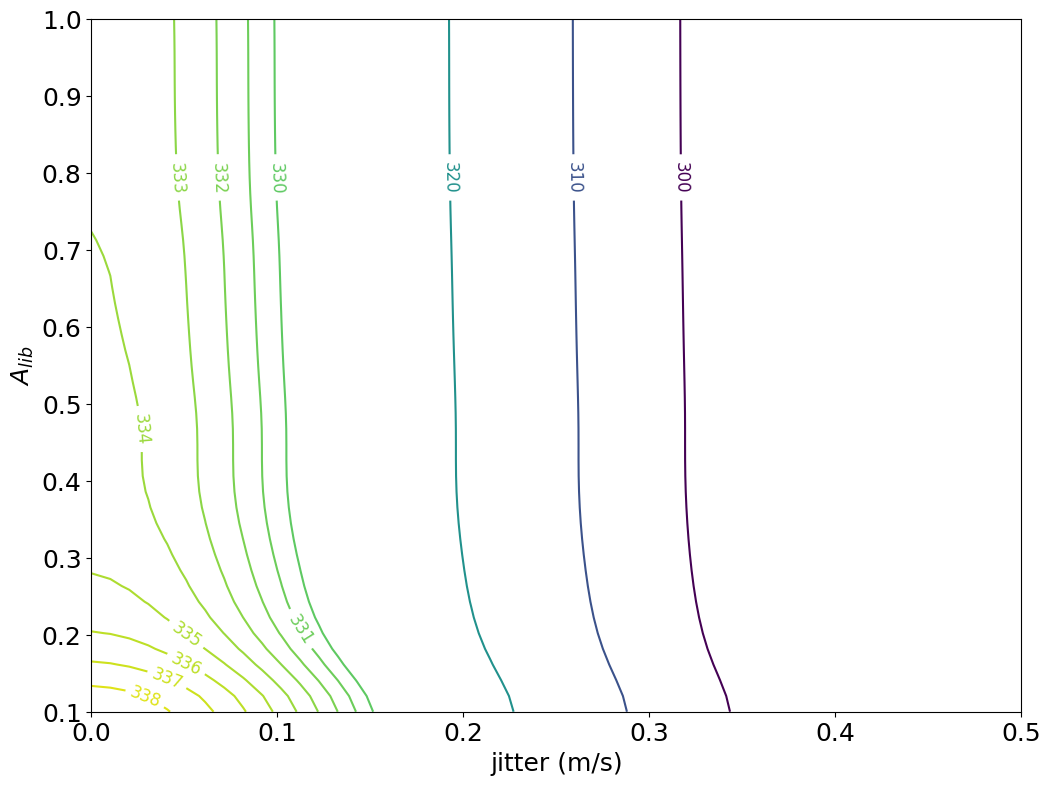

In [44]:
# neg_log_likelihoods_05 = np.load('neg_log_likelihoods_everything_05.npy')
import scipy.ndimage
neg_log_likelihoods_05 = scipy.ndimage.filters.gaussian_filter(neg_log_likelihoods_05, 2.)

plt.figure(figsize = (12, 9))
fig3 = plt.contour(jitters_grid_05, Alibs_grid_05, neg_log_likelihoods_05, levels=[300, 310, 320, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340])
plt.clabel(fig3, inline=True, fontsize=12)
plt.ylim(top=1.)
plt.xlabel('jitter (m/s)'), plt.ylabel(r'$A_{lib}$')

#### Figure in paper; Alib-jitter plot 

Methodology: 
- Take full set of planet parameters, but hold A_lib and jitter constant across a grid of values
- Optimize the function `get_nbody_results_jitter_libration()` which is the same least-squares function for RVs used, but with an additional penalty for the RMS libration amplitude, for each set of parameters
- Then compute the negative log-likelihood of each set of parameters following Eq. 1 of (https://iopscience.iop.org/article/10.1088/0004-637X/794/1/51/pdf), which takes into account all parameters (including jitter) but not libration
- Plot the best-fit point (lowest log-likelihood) and likelihood contours of best fit $\mathcal{L}$ + ($1$, $4$, $9$) corresponding to ($1, 2, 3 \sigma$) from best-fit likelihood

Results strongly suggests nonzero jitter but shows that A_lib doesn't matter until a very strong penalty is applied (below $A \approx 0.3$) and that the fit is better with a weaker penalty

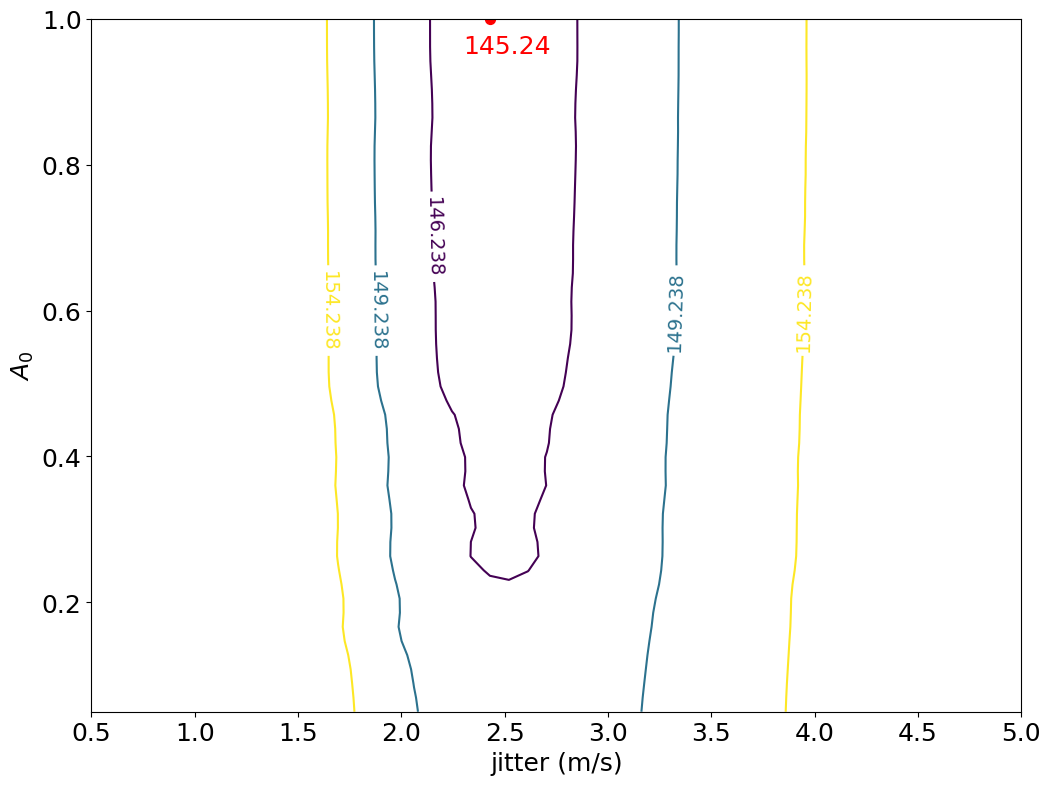

In [36]:
import scipy.ndimage
neg_log_likelihoods = np.load('neg_log_likelihoods_everything_contours.npy')

sigma=1.
neg_log_likelihoods = scipy.ndimage.filters.gaussian_filter(neg_log_likelihoods, sigma)

# min_likelihood = 144.46
min_likelihood = np.min(neg_log_likelihoods)
min_likelihood_index = tuple(np.argwhere(neg_log_likelihoods == min_likelihood).reshape(-1))

# locations of contour labels
manual_locations = [(2.4, 0.7), (1.7, 0.6), (2.0, 0.6), (3.3, 0.6), (3.9, 0.6)]
# levels
levels = [min_likelihood + 1, min_likelihood + 4, min_likelihood + 9]
# levels = [min_likelihood + 1, min_likelihood + 4, min_likelihood + 9, 
#                             min_likelihood + 16, min_likelihood + 25, min_likelihood + 36, 
#                             min_likelihood + 49, min_likelihood + 64, min_likelihood + 81, 
#                             min_likelihood + 100]

# plotting
plt.figure(figsize = (12, 9))
fig = plt.contour(jitters_grid, Alibs_grid, neg_log_likelihoods, 
                  levels = levels, 
                  label='negative log likelihoods')
# fig2 = plt.contour(jitters_grid_05, Alibs_grid_05, neg_log_likelihoods_05, levels = [396, 397, 397.5])
plt.scatter(jitters_grid[min_likelihood_index], Alibs_grid[min_likelihood_index], label = 'Best fit', color='red', s=50)
plt.annotate(f'{np.round(min_likelihood, 2)}', xy=(jitters_grid[min_likelihood_index], Alibs_grid[min_likelihood_index]), 
              xycoords='data', textcoords='axes fraction', xytext=(0.4, 0.95), color='red')
plt.xlabel('jitter (m/s)'), plt.ylabel(r'$A_{0}$')
plt.clabel(fig, inline=True, fontsize=14, manual=manual_locations)
# plt.clabel(fig, inline=True, fontsize=14)
# plt.clabel(fig2, inline=True, fontsize=14)
# yticks
plt.tick_params(axis='y', which='minor')
# plt.set_tick_params(which='minor', bottom=False)
plt.ylim(top=1.0)
# plt.legend(loc='upper right')
plt.savefig('2021_fall-2022_winter/paper_figures/Alib_jitter_sini_contour.png')#, fmt='png')

Finding the approximate value of $1\sigma_\text{jit}$:

In [37]:
jitter_range = jitters_grid[0][[np.argwhere(neg_log_likelihoods[0] < np.min(neg_log_likelihoods[0] + 1))]]
onesigma_jit = (np.max(jitter_range) - np.min(jitter_range))/2
onesigma_jit

0.3214285714285716

Optional: Now compute and plot the likelihood for varying $A_0$ while holding jitter at $0$:

In [50]:
nlib = 150
Alibs = np.linspace(1.1, 0.05, nlib)

neg_log_likelihoods_zero_jitter = np.zeros(nlib)

x0 = fit_params
for j in tqdm(range(nlib)):
    # get the A0, jitter point on the grid
    Alib = Alibs[j]  
    jitter = 0.
    # optimize the parameters, holding A0 and jitter constant at the specified grid point
    Alib_jitter_fit_params = optimize.least_squares(lambda params: get_nbody_resids_jitter_libration(params, jitter=jitter, Alib=Alib), 
                                                    x0, bounds=bounds2, ftol=1e-12, xtol=1e-12, verbose=0).x
    # then compute the negative log likelihood of fit just from the parameters (not the total cost function including the libration penalty term)
    # add jitter back to the parameters
    Alib_jitter_fit_params[-1] = jitter 
    # plug params into negative log likelihood and record it
    neg_log_likelihoods_zero_jitter[j] = neg_log_likelihood(Alib_jitter_fit_params)
    # update fit params with previous value
    x0 = Alib_jitter_fit_params

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [12:47<00:00,  5.11s/it]


Optional: Save/load:

In [55]:
# save
# np.save('neg_log_likelihoods_zero_jitter', neg_log_likelihoods_zero_jitter)

# load
neg_log_likelihoods_zero_jitter = np.load('neg_log_likelihoods_zero_jitter.npy')

Plot:

(-0.0025000000000000022, 1.0)

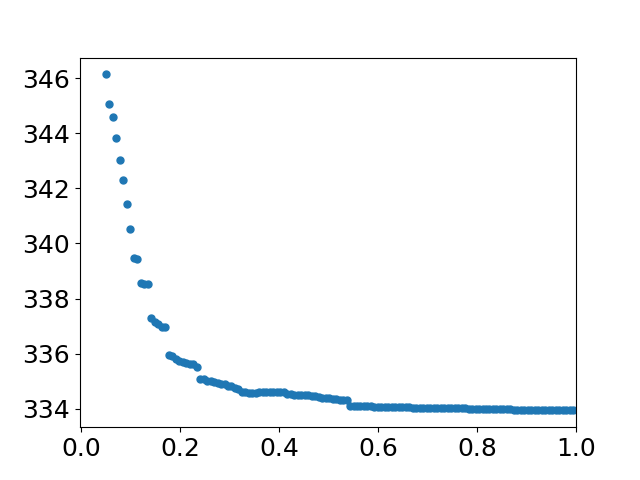

In [56]:
plt.figure()
plt.scatter(Alibs, neg_log_likelihoods_zero_jitter)
plt.xlim(right=1.)
# plt.ylim(396, 399)

### Testing/Debugging:

In [42]:
Alibs[75]

0.30454545454545456

In [43]:
test_fit_params = optimize.least_squares(lambda params: get_nbody_resids_jitter_libration(params, jitter=0., Alib=Alibs[75]), 
                                                fit_params, bounds=bounds2, verbose=0).x

In [44]:
test_fit_params

array([ 2.28500263e+02,  7.27740751e+00,  5.39371913e+04, -4.92940348e-02,
       -1.61370447e-01,  3.43385758e+02,  1.78605456e+01,  5.40186750e+04,
        9.77368753e-02,  1.16472358e-01, -5.28690875e-01,  9.98593841e-01,
        2.42800000e+00])

In [45]:
test_fit_params[-1] = 0
neg_log_likelihood(test_fit_params)

347.73316638730347

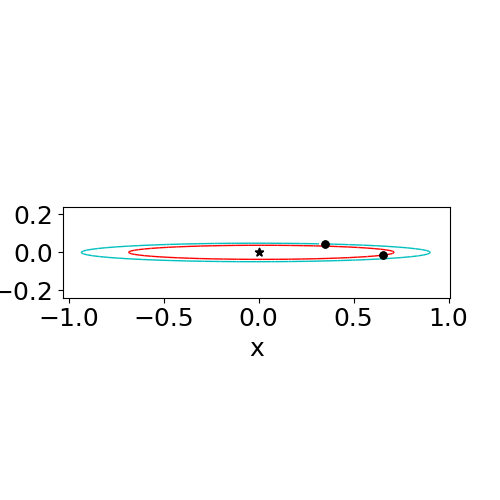

In [46]:
%matplotlib widget
sim = get_sim_from_params(test_fit_params, integrator='ias15', time_base=obs_time_base)
op = rb.OrbitPlot(sim, orbit_style='solid', color=True)
fig = op.fig
for i in range(100):
    op.sim.integrate(sim.t+1000)
    op.update()       # update data
    op.fig.savefig("op_frames/out_%02d.png"%i)

In [36]:
plt.scatter(cluster2samples[200:].reshape(-1, 13)[:,-1], cluster2log_prob[200:].reshape(-1))
plt.ylim(-180, -140)

NameError: name 'cluster2samples' is not defined

In [77]:
testdata = h5py.File('mcmc_hd45364_test_everything_with_libration_penalty.h5', 'r')
clusterdata = h5py.File('2021_fall-2022_winter/mcmc_hd45364_cluster_everything.h5', 'r')

In [78]:
testdata, clusterdata

(<HDF5 file "mcmc_hd45364_test_everything_with_libration_penalty.h5" (mode r)>,
 <HDF5 file "mcmc_hd45364_cluster_everything.h5" (mode r)>)

In [79]:
clusteraccepted, clustersamples, clusterlog_prob = np.array(clusterdata['mcmc']['accepted']), np.array(clusterdata['mcmc']['chain']), np.array(clusterdata['mcmc']['log_prob'])

In [80]:
testaccepted, testsamples, testlog_prob = np.array(testdata['mcmc']['accepted']), np.array(testdata['mcmc']['chain']), np.array(testdata['mcmc']['log_prob'])

In [84]:
clusterlog_prob[0], testlog_prob[0]

(array([         -inf, -146.51678715,          -inf,          -inf,
        -144.47196042, -145.22481037, -149.81785781, -150.14552392,
        -144.65341603,          -inf, -145.0619669 ,          -inf,
        -145.70774688, -145.86152335, -146.69308586,          -inf,
                 -inf,          -inf,          -inf, -147.66977602,
        -146.43029218,          -inf, -148.13441221, -144.43619085,
        -145.21614697, -144.98678277,          -inf, -144.89881705,
                 -inf,          -inf, -144.98201814, -144.96430861,
                 -inf,          -inf, -144.6004966 ,          -inf,
        -150.14182548, -144.41217735,          -inf, -146.38755823,
                 -inf, -145.63305125,          -inf,          -inf,
        -144.65213382, -144.85934061, -147.60115545, -144.5074776 ,
                 -inf, -146.30119724]),
 array([          -inf,           -inf,           -inf,           -inf,
                  -inf,           -inf, -3445.53532335,           -inf,


#### extra:

Testing to make sure I can get a jacobian that's nonzero for every parameter:

In [ ]:
# jacobian_fit_params = optimize.least_squares(lambda params: get_nbody_resids_jitter_libration2(params, Alib=1, integrator='ias15'), best_fit_jitter2.x, bounds=bounds2)
jacobian_fit_params = optimize.least_squares(lambda params: get_nbody_resids(params, integrator='ias15'), best_fit_jitter2.x, bounds=bounds2)

In [ ]:
jacobian_fit_params.x, best_fit_jitter2.x

In [ ]:
j = jacobian_fit_params.jac
j[-1][-1] = onesigma_jit
np.linalg.inv(j.T @ j)

In [ ]:
neg_log_likelihood(jacobian_fit_params.x), neg_log_likelihood(best_fit_jitter2.x)

In [ ]:
# obs_yerr = hd_data.e_RV_mlc_nzp
# jitter_penalties = [np.sum(np.log(np.sqrt(2 * np.pi * (obs_yerr ** 2 + jitter ** 2)))) for jitter in jitters]

# plt.plot(jitters, jitter_penalties)

# fit_params = np.array([ 2.28306953e+02,  7.26248510e+00,  5.39345613e+04,  4.02153494e-02,
#        -1.76686411e-01,  3.43427379e+02,  1.79425723e+01,  5.40193481e+04,
#         1.01456416e-01,  1.18819868e-01, -4.99414710e-01,  1.00000000e+00])

# result = optimize.least_squares(lambda params: get_nbody_resids_jitter_libration(params, jitter=1, Alib=1), fit_params)

# result2 = optimize.least_squares(lambda params: get_nbody_resids_jitter_libration(params, jitter=2, Alib=1), result.x)

# result3 = optimize.least_squares(lambda params: get_nbody_resids_jitter_libration(params, jitter=3, Alib=1), result2.x)

# result3